<a href="https://colab.research.google.com/github/KamilBienias/data-science/blob/main/kursPawe%C5%82Krakowiak/machine-learning-bootcamp/unsupervised/02_dimensionality_reduction/01_pca_math.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* @author: krakowiakpawel9@gmail.com  
* @site: e-smartdata.org

### scikit-learn
Strona biblioteki: [https://scikit-learn.org](https://scikit-learn.org)  

Dokumentacja/User Guide: [https://scikit-learn.org/stable/user_guide.html](https://scikit-learn.org/stable/user_guide.html)

Podstawowa biblioteka do uczenia maszynowego w języku Python.

Aby zainstalować bibliotekę scikit-learn, użyj polecenia poniżej:
```
!pip install scikit-learn
```
Aby zaktualizować do najnowszej wersji bibliotekę scikit-learn, użyj polecenia poniżej:
```
!pip install --upgrade scikit-learn
```
Kurs stworzony w oparciu o wersję `0.22.1`

### Spis treści:
1. [Import bibliotek](#0)
2. [Wygenerowanie danych](#1)
3. [Wizualizacja danych](#2)
4. [Standaryzacja](#3)
5. [Implementacja PCA](#4)
6. [PCA - scikit-learn](#5)



### <a name='0'></a> Import bibliotek

In [99]:
print("############################################################")
print("Etap9. Odcinek: PCA - Analiza Głównych Składowych - implementacja")

# Wykłady:

# Principal Component Analisys polega na zmniejszeniu liczby zmiennych, tak aby jak najbardziej zachować wariancję.
# Wariancja to średnia kwadratów odchyleń cechy od jej wartości oczekiwanej. 
# Kowariancja określa zależność między dwiema zmiennymi X i Y. Nie jest miarą unormowaną.
# cov(X,X) = var(X).

# v jest wektorem własnym przekształcenia A wyznaczonego przez f: Rn -> Rn, 
# gdy A*v = lambda * v, gdzie lambda jest wartością własną odpowiadającą wektorowi własnemu v.

# k = {t*v : t in R} - prosta w Rn

# lambda jest wartością własną macierzy A <=> det(A - lambda * I) = 0  (równanie charakterystyczne)

# Wyliczone lambdy wstawia się do równania (A - lambda * I) * v = 0 i wylicza się wektory własne odpowiadające wartościom własnym.

# Kroki algorytmu PCA:
# 1. Standaryzacja danych
# 2. Obliczenie macierzy kowariancji
# 3. Wyznaczenie wektorów własnych i wartości własnych macierzy kowariancji
# 4. Posortowanie wartości własnych malejąco
# 5. Wybór liczby głównych komponentów
# 6. Konstrukcja macierzy rzutu z wybranych wektorów własnych
# 7. Projekcja (rzut) na nową przestrzeń cech

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

np.set_printoptions(precision=8, suppress=True, edgeitems=5, linewidth=200)

############################################################
Etap9. Odcinek: PCA - Analiza Głównych Składowych - implementacja


### <a name='1'></a> Wygenerowanie danych

In [100]:
from sklearn.datasets import load_iris

raw_data = load_iris()
data = raw_data['data']
target = raw_data['target']
feature_names = list(raw_data['feature_names'])
# robi żeby nazwy cech bez spacji i bez (cm)
feature_names = [name.replace(' ', '_')[:-5] for name in feature_names]
df = pd.DataFrame(data=np.c_[data, target], columns=feature_names + ['class'])
# w kolumnie class zamienia 0.0 na 'setosa', 1.0 na 'versicolor' i 2.0 na 'virginica'
df['class'] = df['class'].map({0.0: 'setosa', 1.0: 'versicolor', 2.0: 'virginica'})
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### <a name='2'></a> Wizualizacja danych

In [101]:
px.scatter_3d(df, x='sepal_length', y='petal_length', z='petal_width', template='plotly_dark',
              title='Iris data - wizualizacja 3D (sepal_length, petal_length, petal_width)',
              color='class', symbol='class', opacity=0.5, width=950, height=700)
 
# chcę te 3 zmienne zamienić na dwie zmienne: pca1 i pca2

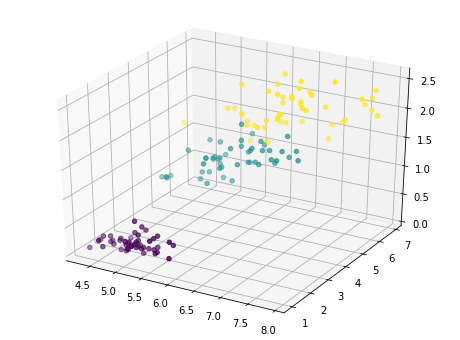

In [102]:
# sam robię w matplotlib bo na github nie widać plotly
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8.0,6.0))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['sepal_length'], df['petal_length'], df['petal_width'], c=raw_data['target'])
plt.show()

### <a name='3'></a> Standaryzacja

In [103]:
# standaryzacja czyli odejmuje średnią i dzieli przez odchylenie standardowe
from sklearn.preprocessing import StandardScaler
# z df biorę kolumny 0, 2 i 3 czyli 'sepal_length', 'petal_length', 'petal_width' 
X = df.iloc[:, [0, 2, 3]]
# z df biorę ostatnią kolumnę, którą jest 'class'
y = df.iloc[:, -1]

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std[:5]

array([[-0.90068117, -1.34022653, -1.3154443 ],
       [-1.14301691, -1.34022653, -1.3154443 ],
       [-1.38535265, -1.39706395, -1.3154443 ],
       [-1.50652052, -1.2833891 , -1.3154443 ],
       [-1.02184904, -1.34022653, -1.3154443 ]])

### <a name='4'></a> Implementacja PCA

In [104]:
# macierz kowariancji. Na przekątnej są wariancje.
# Bez rowvar=False wychodzi macierz o wymiarach (150,150)
cov_mat = np.cov(X_std, rowvar=False)
cov_mat

array([[1.00671141, 0.87760447, 0.82343066],
       [0.87760447, 1.00671141, 0.96932762],
       [0.82343066, 0.96932762, 1.00671141]])

In [105]:
# wektory własne i odpowiadające im wartości własne macierzy kowariancji
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print(f'Wartości własne:\n{eig_vals}\n')
# wektory własne są w pionowych kolumnach
print(f'Wektory własne:\n{eig_vecs}')

Wartości własne:
[2.78833033 0.20075012 0.03105378]

Wektory własne:
[[ 0.55964149  0.81270446  0.16221241]
 [ 0.59148855 -0.2546058  -0.76506024]
 [ 0.58046765 -0.52410624  0.62319335]]


In [106]:
# posortowanie wektorów według wartości własnych (od największej)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(reverse=True)
eig_pairs

[(2.788330329675293, array([0.55964149, 0.59148855, 0.58046765])),
 (0.20075011806343768, array([ 0.81270446, -0.2546058 , -0.52410624])),
 (0.03105378044919023, array([ 0.16221241, -0.76506024,  0.62319335]))]

In [107]:
# obliczenie wartości procentowej wyjaśnionej wariancji
total = sum(eig_vals)
explained_variance_ratio = [(i / total) for i in sorted(eig_vals, reverse=True)]
explained_variance_ratio
# pierwsza główna składowa trzyma ponad 92% wariancji całych danych

[0.9232471536035965, 0.06647059464767155, 0.01028225174873187]

In [108]:
# skumulowana wariancja
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
cumulative_explained_variance

array([0.92324715, 0.98971775, 1.        ])

In [109]:
results = pd.DataFrame(data={'explained_variance_ratio': explained_variance_ratio})
# cumulative to skumulowana wyjaśniona wariancja
results['cumulative'] = results['explained_variance_ratio'].cumsum()
results['component'] = results.index + 1
results

,explained_variance_ratio,cumulative,component
0,0.923247,0.923247,1
1,0.066471,0.989718,2
2,0.010282,1.000000,3


In [110]:
fig = go.Figure(data=[go.Bar(x=results['component'], y=results['explained_variance_ratio'], name='explained variance ratio'),
                      go.Scatter(x=results['component'], y=results['cumulative'], name='cumulative explained variance')],
                layout=go.Layout(title='PCA - 3 components', width=950, template='plotly_dark'))
fig.show()

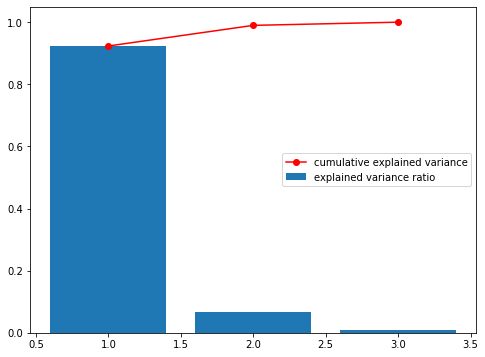

In [111]:
# sam robię w matplotlib bo na github nie widać plotly
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8.0,6.0))
ax = fig.add_subplot(111)
ax.bar(results['component'], results['explained_variance_ratio'],
label='explained variance ratio')
ax.plot(results['component'], results['cumulative'], marker='o', label='cumulative explained variance', c="red")
plt.legend(loc='center right')
plt.show()

In [112]:
# przypomnienie par wektor własny - wartość własna
eig_pairs

[(2.788330329675293, array([0.55964149, 0.59148855, 0.58046765])),
 (0.20075011806343768, array([ 0.81270446, -0.2546058 , -0.52410624])),
 (0.03105378044919023, array([ 0.16221241, -0.76506024,  0.62319335]))]

In [113]:
# 2 komponenty, W - macierz składająca się z 2 wektorów własnych mających największą wartość własną
# Wydobywa dwa pierwsze wektory z eig_pairs. One z wierszy będą kolumnami. 
W = np.hstack((eig_pairs[0][1].reshape(3, 1), eig_pairs[1][1].reshape(3, 1)))
W

array([[ 0.55964149,  0.81270446],
       [ 0.59148855, -0.2546058 ],
       [ 0.58046765, -0.52410624]])

In [114]:
X_pca = X_std.dot(W)
pca_df = pd.DataFrame(data=X_pca, columns=['pca_1', 'pca_2'])
pca_df['class'] = df['class']
pca_df['pca_2'] = - pca_df['pca_2']
pca_df

,pca_1,pca_2,class
0,-2.060360,-0.298674,setosa
1,-2.195981,-0.101727,setosa
2,-2.365221,0.080749,setosa
3,-2.365794,0.208165,setosa
4,-2.128171,-0.200201,setosa
...,...,...,...
145,1.906692,0.124424,virginica
146,1.262579,0.213420,virginica
147,1.541846,0.114404,virginica
148,1.634876,0.645735,virginica


In [131]:
px.scatter(pca_df, 'pca_1', 'pca_2', color='class', width=900, template='plotly_dark')

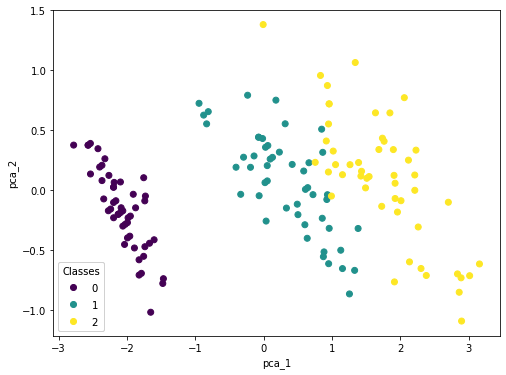

In [142]:
# sam robię w matplotlib bo na github nie widać plotly
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8.0,6.0))
ax = fig.add_subplot(111)
punktowy = ax.scatter(pca_df['pca_1'], pca_df['pca_2'], c=raw_data['target'])
plt.xlabel("pca_1")
plt.ylabel("pca_2")
# bez poniższego wyświetlałoby legendę do każdego z 150 punktów osobno. Wzięte z:
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/scatter_with_legend.html
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*punktowy.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

### <a name='5'></a> PCA - scikit-learn

In [117]:
# to samo ale z sklearn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
# na danych wystandaryzowanych
X_pca = pca.fit_transform(X_std)
pca_df = pd.DataFrame(data=X_pca, columns=['pca_1', 'pca_2'])
pca_df['class'] = df['class']
pca_df

,pca_1,pca_2,class
0,-2.060360,-0.298674,setosa
1,-2.195981,-0.101727,setosa
2,-2.365221,0.080749,setosa
3,-2.365794,0.208165,setosa
4,-2.128171,-0.200201,setosa
...,...,...,...
145,1.906692,0.124424,virginica
146,1.262579,0.213420,virginica
147,1.541846,0.114404,virginica
148,1.634876,0.645735,virginica


In [130]:
px.scatter(pca_df, 'pca_1', 'pca_2', color='class', width=900, template='plotly_dark')

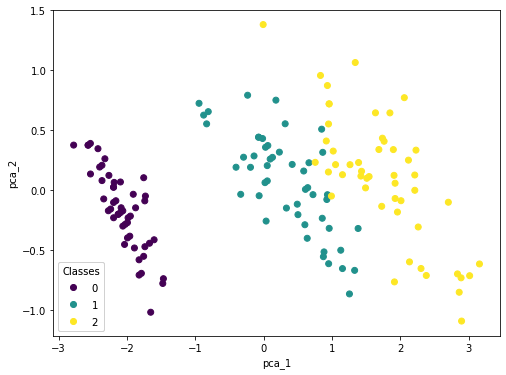

In [141]:
# sam robię w matplotlib bo na github nie widać plotly
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8.0,6.0))
ax = fig.add_subplot(111)
punktowy = ax.scatter(pca_df['pca_1'], pca_df['pca_2'], c=raw_data['target'])
plt.xlabel("pca_1")
plt.ylabel("pca_2")
# bez poniższego wyświetlałoby legendę do każdego z 150 punktów osobno. Wzięte z:
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/scatter_with_legend.html
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*punktowy.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()